In [1]:
# Torch #
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim

# Torchvision #
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Torchtrainer #
import torchtrainer
from torchtrainer import SupervisedTrainer
from torchtrainer.base import ValidationGranularity
from torchtrainer.meters import CategoricalAccuracy
from torchtrainer.callbacks import ProgbarLogger as Logger

from matplotlib import pyplot as plt

In [2]:
BATCH_SIZE = 300
VAL_BATCH_SIZE = 300
CUDA = True
LR = 1e-2

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.filter = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm2d(32),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm2d(64),
                                    nn.MaxPool2d(2))
        self.linear = nn.Sequential(nn.Linear(5*5*64, 500),
                                    nn.BatchNorm1d(500),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(500, 10))

    def forward(self, x):
        bs = x.shape[0]
        return self.linear(self.filter(x).view(bs, -1))

In [4]:
train_ds = MNIST(root='/tmp/data/mnist', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_ds = MNIST(root='/tmp/data/mnist', download=False, train=False, transform=transforms.Compose([transforms.ToTensor()]))    

In [5]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=VAL_BATCH_SIZE)

In [6]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [7]:
trainer = SupervisedTrainer(model=model,
                            optimizer='sgd',
                            criterion='cross_entropy',
                            logging_frecuency=10,
                            acc_meters={'acc': 'categorical_accuracy_percentage'},
                            callbacks=[Logger(notebook=True, monitors=('train_acc', 'val_acc'))],
                            validation_granularity=ValidationGranularity.AT_LOG)

In [8]:
if CUDA:
    trainer.cuda()

In [9]:
trainer.train(dataloader=train_dl, valid_dataloader=test_dl, epochs=5)

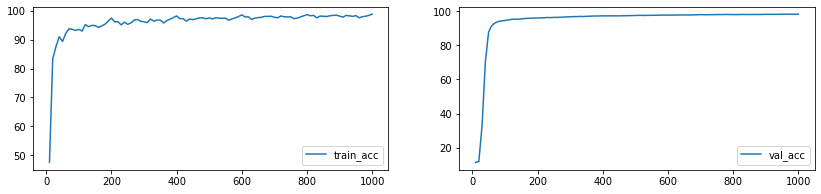

In [10]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
trainer.history.step_plot('train_acc')
plt.subplot(1,2,2)
trainer.history.step_plot('val_acc')
plt.show()